# DTSA 5511 Introduction to Deep Learning Final Project

## Deep Learning Problem
### This project is based on the Kaggle competition "House Prices - Advanced Regression Techniques" which can be found here: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques. The goal of the project is to use deep learning regression to predict the sales price of a house in Ames, Iowa, given 79 different categorical and numerical features.

## Exploratory Data Analysis
### We begin by reading in our data and looking at the head and shape of it. We can see that we have 1459 rows and 81 columns, and we can already see a number of NaN values in our data. We go ahead and drop the "Id" column of the training data so that it doesn't confuse the regressor. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf

train_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")

print(f"Shape of training data: {train_df.shape}\n")
print(train_df.head())

# No need for Id column in training data
train_df.drop("Id", axis=1, inplace=True)

2024-04-30 04:04:35.501356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 04:04:35.501413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 04:04:35.503024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Shape of training data: (1460, 81)

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleConditio

### Looking at our factors, we have 3 floats, 34 integers, and 43 objects, and quite a few of our columns have null values, some of them predominantly so.

In [2]:
print("\nFactors in Our Data:\n")
print(train_df.info())


Factors in Our Data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null 

### Our home sale price column serves as our label, so we want to make sure that it looks normal. It has no 0 values or extremely high values, and the distribution is left skewed. Nothing to worry about.

Distribution of Home Sale Prices:

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64




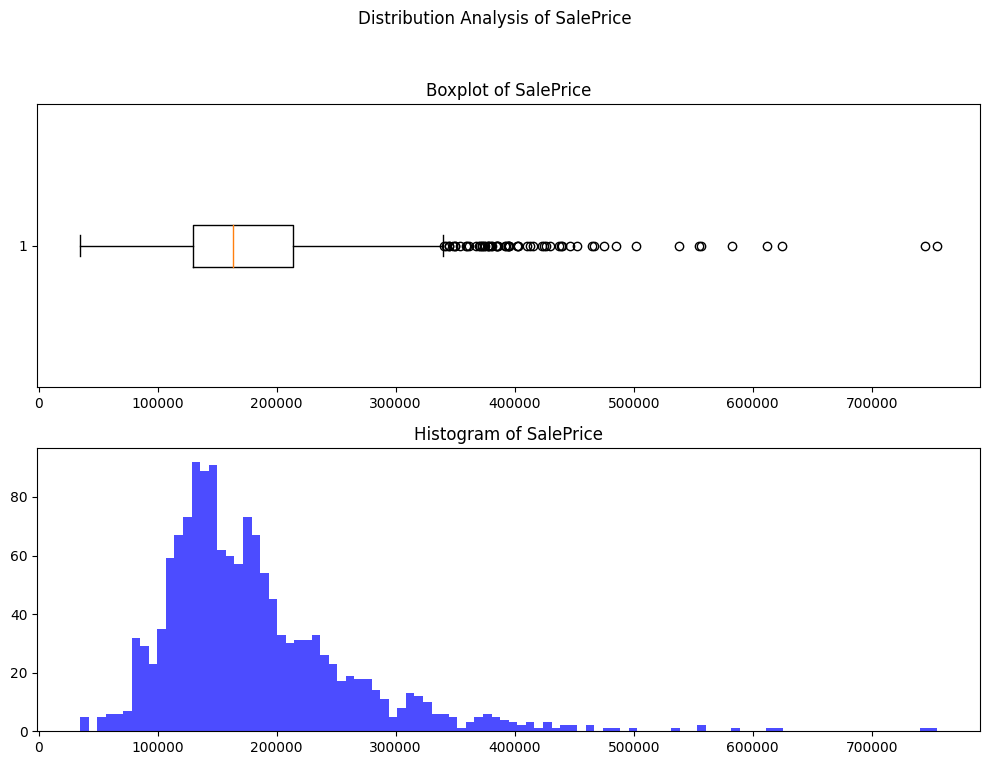

In [3]:
print("Distribution of Home Sale Prices:\n")
print(train_df["SalePrice"].describe())
print("\n")

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Boxplot
axs[0].boxplot(train_df["SalePrice"], vert=False)
axs[0].set_title("Boxplot of SalePrice")

# Histogram
axs[1].hist(train_df["SalePrice"], bins=100, alpha=0.7, color="blue")
axs[1].set_title("Histogram of SalePrice")

# Set overall title
plt.suptitle("Distribution Analysis of SalePrice")

# Show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the rect to make space for the suptitle
plt.show()

### Looking at the histograms of our data distributions, we see that a number of our numerical values have so few unique values that they're essentially categorical. Other more continuous values have more meaningful distributions.

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

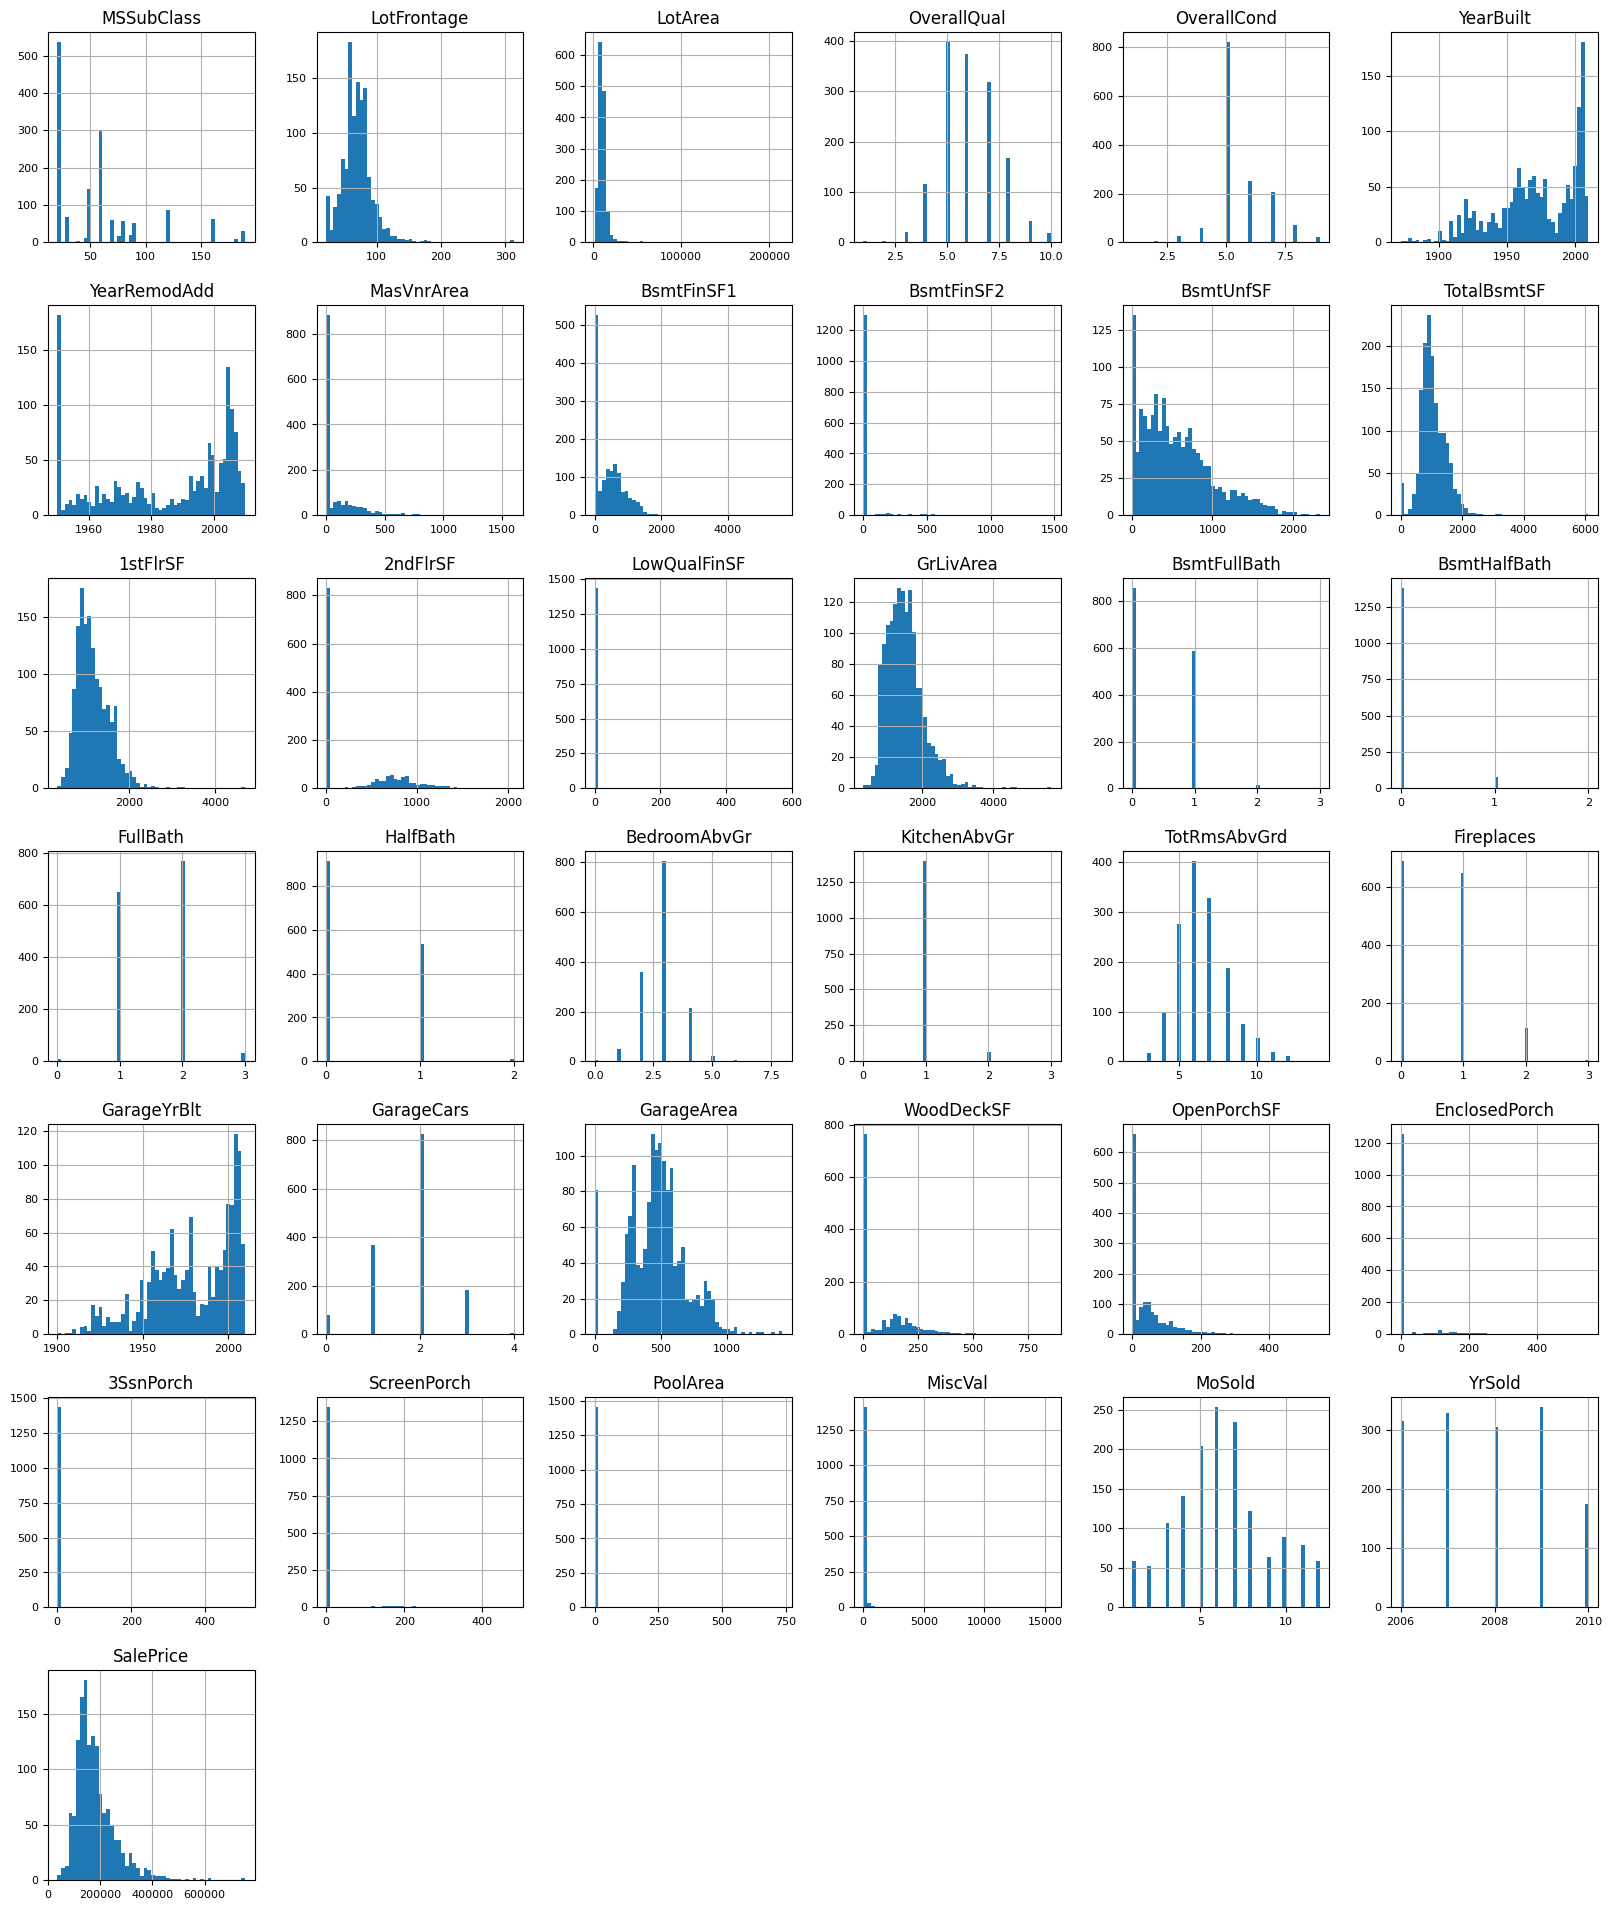

In [4]:
train_df_num = train_df.select_dtypes(include=["float64", "int64"])
train_df_num.hist(figsize=(20, 24), bins=50, xlabelsize=8, ylabelsize=8)

### As far as correlation between our numerical factors, looking at our heatmap allows us to say that there are no noteworthy correlations between them.

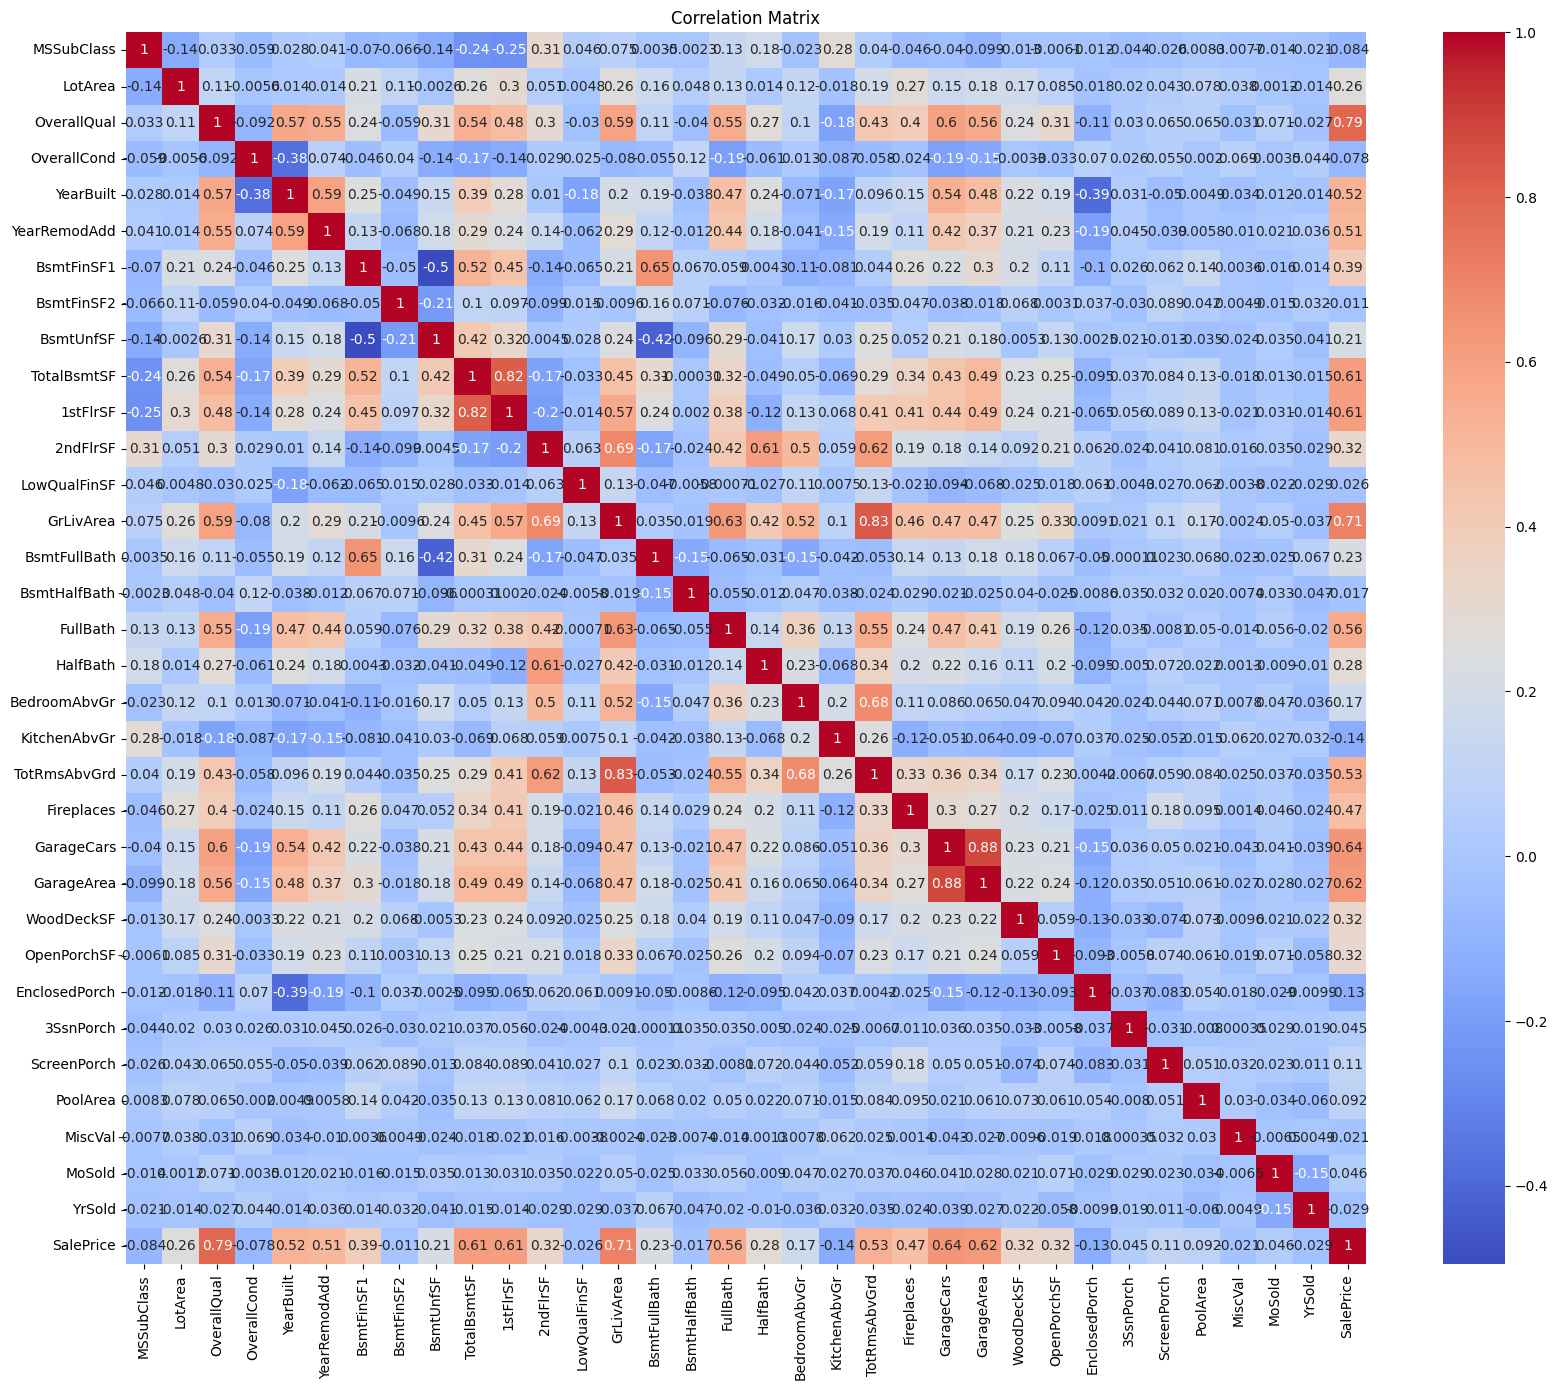

In [5]:
import seaborn as sns

num_df = train_df.select_dtypes(include=["number"])
num_df.dropna(axis=1, inplace=True)

corr_mat = num_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_mat, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Model Building
### After dropping our non-numerical columns and columns containing NaN values, we begin by splitting our data into x and y training and validation data.

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
#from keras.wrappers.scikit_learn import KerasRegressor
#from scikeras.wrappers import KerasRegressor
#from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline #***
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras

X = num_df.drop("SalePrice", axis=1)
y = num_df["SalePrice"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=64)

### I decided to go with a Sequential keras model with a number of Dense layers with relu activation that are followed by Dropout layers. A final Dense layer is used as an output layer for the regression, and we use the Adam optimizer with MSE loss. There are 3 different sets of hyperparameters for 3 different models, and each model was evaluated based on RMSE and training time.

In [7]:
# Define the model architecture
def build_model(hidden_layers=1, neurons_per_layer=64, dropout_rate=0.2, epochs=50, batch_size=32):
    model = keras.Sequential()
    model.add(keras.layers.Input([X_train.shape[1]]))
    model.add(keras.layers.Dense(neurons_per_layer, activation="relu"))
    
    # Add hidden layers dynamically
    for i in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons_per_layer, activation="relu"))
        model.add(keras.layers.Dropout(dropout_rate))
    
    model.add(keras.layers.Dense(1))  # Output layer for regression
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    return model

# Define a function to manually evaluate the model with different hyperparameters
def evaluate_model(X_train, y_train, X_val, y_val, hyperparams):
    model = build_model(**hyperparams)
    
    # Train the model
    model.fit(X_train, y_train, epochs=hyperparams.get("epochs", 50), batch_size=hyperparams.get("batch_size", 32))
    
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    res_rmse.append(rmse)
    print(f"RMSE with hyperparams {hyperparams}:\n{rmse}")
    
    return model

hyperparam_combinations = [
    {"hidden_layers": 1, "neurons_per_layer": 32, "dropout_rate": 0.1, "epochs": 50, "batch_size": 32},
    {"hidden_layers": 2, "neurons_per_layer": 64, "dropout_rate": 0.2, "epochs": 100, "batch_size": 64},
    {"hidden_layers": 3, "neurons_per_layer": 32, "dropout_rate": 0.3, "epochs": 50, "batch_size": 32}
]

## Results and Analysis
### We start by looping through our model evaluation function to build our models with our different hyperparameters.

In [8]:
import time

res_model = [1, 2, 3]
res_rmse = []
res_time = []

for params in hyperparam_combinations:
    time1 = time.time()
    evaluate_model(X_train, y_train, X_val, y_val, params)
    res_time.append(time.time() - time1)

Epoch 1/50
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39972941824.0000

I0000 00:00:1714449896.655678    2573 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 39772504064.0000
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37400109056.0000
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36643303424.0000
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33939173376.0000
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31081994240.0000
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28374077440.0000
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25943572480.0000 
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24579328000.0000 
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20350947328.0000 
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19554496512.0000 
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16711921664.0000
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14167857152.0000
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11441514496.0000
Epoch 14/50
37/37 ━━━━━━━━━

### Looking at our resulting visualizations, our third model (the one with the most hidden layers) had the lowest RMSE but the longest execution time, with the other 2 models following the same trend.

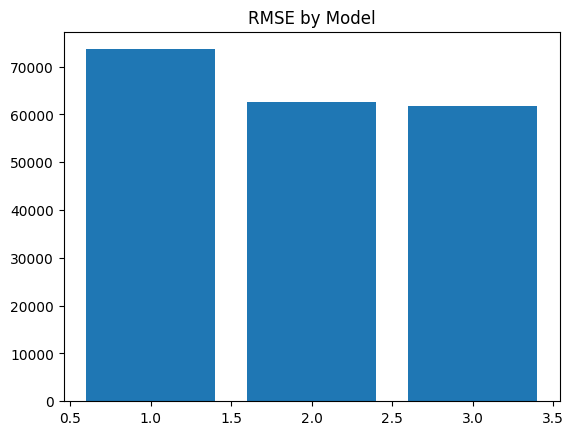

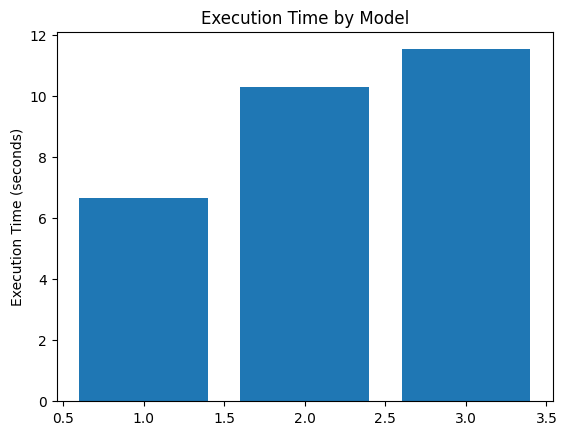

In [9]:
res_df = pd.DataFrame({
    "Model": res_model,
    "Time": res_time,
    "RMSE": res_rmse
})

plt.bar(res_df["Model"], res_df["RMSE"])
plt.title("RMSE by Model")
plt.show()

plt.bar(res_df["Model"], res_df["Time"])
plt.title("Execution Time by Model")
plt.ylabel("Execution Time (seconds)")
plt.show()

## Conclusion
### In conclusion, our results were not fantastic in terms of RMSE. Unfortunately, I have run out of time for further testing, but if I had more time, I would add a lot more hidden layers to the model, and normalize the numerical training data. What I did find is that the more hidden Dense and Dropout layers, the better the RMSE but the longer the execution time.

## GitHub link: https://github.com/mwcarlson/DS_ML_DL_FP